In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_movies = pd.read_csv("./zee-movies.dat", delimiter='::', encoding="windows-1252")
df_ratings = pd.read_csv("./zee-ratings.dat", delimiter='::')
df_users = pd.read_csv("./zee-users.dat", delimiter='::')

In [3]:
df_movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
print(df_movies.shape)
print(df_ratings.shape)
print(df_users.shape)

(3883, 3)
(1000209, 4)
(6040, 5)


In [7]:
df_movies.nunique()

Movie ID    3883
Title       3883
Genres       301
dtype: int64

In [8]:
df_users.nunique()

UserID        6040
Gender           2
Age              7
Occupation      21
Zip-code      3439
dtype: int64

In [9]:
print(df_movies.isna().sum())
print(df_ratings.isna().sum())
print(df_users.isna().sum())

Movie ID    0
Title       0
Genres      0
dtype: int64
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


Filtering only those movies for which the ratings were done most frequently:

In [10]:
df_ratings.MovieID.value_counts().head(1000)

MovieID
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
2318     320
69       319
2819     319
1769     319
1031     319
Name: count, Length: 1000, dtype: int64

In [11]:
select_movies = df_ratings.MovieID.value_counts().head(1000).index.to_list()
len(select_movies)

1000

## Transforming Movie Genres into Binary Features
- Extracting year and title from movie title column
- Let's Split and create OHE Columns from Genre String

In [12]:
import re

def parse_movie_info(movie_string):
    # Regular expression to match the movie name and release year
    pattern = r"^(.*)\s\((\d{4})\)$"
    match = re.match(pattern, movie_string)

    if match:
        movie_name = match.group(1)
        release_year = match.group(2)
        return movie_name, release_year
    else:
        return None, None

# Example usage
input_string = "Inception (2010)"
result = parse_movie_info(input_string)

print(f"Movie Name: {result[0]}")
print(f"Release Year: {result[1]}")

Movie Name: Inception
Release Year: 2010


In [13]:
movies = df_movies.copy()

In [14]:
movies['movie_name'] = movies['Title'].apply(lambda x: parse_movie_info(x)[0])
movies['release_year'] = movies['Title'].apply(lambda x: parse_movie_info(x)[1])
movies.head()

,Movie ID,Title,Genres,movie_name,release_year
0,1,Toy Story (1995),Animation|Children's|Comedy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


In [15]:
movies['Genres'] = movies['Genres'].str.split('|')
movies['Genres']

0        [Animation, Children's, Comedy]
1       [Adventure, Children's, Fantasy]
2                      [Comedy, Romance]
3                        [Comedy, Drama]
4                               [Comedy]
                      ...               
3878                            [Comedy]
3879                             [Drama]
3880                             [Drama]
3881                             [Drama]
3882                   [Drama, Thriller]
Name: Genres, Length: 3883, dtype: object

In [16]:
movies = movies.explode('Genres')
movies.head()

,Movie ID,Title,Genres,movie_name,release_year
0,1,Toy Story (1995),Animation,Toy Story,1995
0,1,Toy Story (1995),Children's,Toy Story,1995
0,1,Toy Story (1995),Comedy,Toy Story,1995
1,2,Jumanji (1995),Adventure,Jumanji,1995
1,2,Jumanji (1995),Children's,Jumanji,1995


In [17]:
movies = movies.pivot(index=['Movie ID', 'movie_name', 'release_year'], columns='Genres', values='Title')
movies.head()

,,Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie ID,movie_name,release_year,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,NaN,NaN,Toy Story (1995),Toy Story (1995),Toy Story (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Jumanji,1995,NaN,Jumanji (1995),NaN,Jumanji (1995),NaN,NaN,NaN,NaN,Jumanji (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Grumpier Old Men,1995,NaN,NaN,NaN,NaN,Grumpier Old Men (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grumpier Old Men (1995),NaN,NaN,NaN,NaN
4,Waiting to Exhale,1995,NaN,NaN,NaN,NaN,Waiting to Exhale (1995),NaN,NaN,Waiting to Exhale (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Father of the Bride Part II,1995,NaN,NaN,NaN,NaN,Father of the Bride Part II (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
movies = ~movies.isna()
movies = movies.astype(int)
movies

,,Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie ID,movie_name,release_year,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jumanji,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,Meet the Parents,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,Requiem for a Dream,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3950,Tigerland,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [19]:
movies = movies.reset_index()
movies.head()



Genres,Movie ID,movie_name,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
movies.set_index('Movie ID', inplace=True, drop='index')
movies = movies.reset_index()
movies.head()

Genres,Movie ID,movie_name,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Let's Extract Hour from Timestamp
- Extracting the hour from the timestamp can indeed serve as a valuable user feature.
- By incorporating the hour of the day when users provide ratings, it provides a means to capture time-based patterns and behaviors of users.

In [21]:
ratings = df_ratings.copy()
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [22]:
x = 956716541
datetime.fromtimestamp(x).hour
datetime.fromtimestamp(x).weekday()
# r.tail()

2

In [23]:
ratings['hour'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
ratings['day'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).day)
ratings['weekday'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).weekday())
ratings['month'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).month)
ratings['year'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).year)
ratings['date'] = ratings['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).date())

ratings.head()


,UserID,MovieID,Rating,Timestamp,hour,day,weekday,month,year,date
0,1,1193,5,978300760,3,1,0,1,2001,2001-01-01
1,1,661,3,978302109,4,1,0,1,2001,2001-01-01
2,1,914,3,978301968,4,1,0,1,2001,2001-01-01
3,1,3408,4,978300275,3,1,0,1,2001,2001-01-01
4,1,2355,5,978824291,5,7,6,1,2001,2001-01-07


### Now, Let's Read and Merge User Data with Aggregated Values:

In [24]:
users_ratings_stat = df_users.merge(ratings.groupby('UserID').Rating.mean().reset_index(), on='UserID')
users_ratings_stat = users_ratings_stat.merge(ratings.groupby('UserID').hour.mean().reset_index(), on='UserID')
users_ratings_stat = users_ratings_stat.merge(ratings.groupby('UserID').day.mean().reset_index(), on='UserID')
users_ratings_stat = users_ratings_stat.merge(ratings.groupby('UserID').weekday.mean().reset_index(), on='UserID')
users_ratings_stat = users_ratings_stat.merge(ratings.groupby('UserID').month.mean().reset_index(), on='UserID')
users_ratings_stat = users_ratings_stat.merge(ratings.groupby('UserID').year.mean().reset_index(), on='UserID')
users_ratings_stat = users_ratings_stat.merge(ratings.groupby('UserID').Timestamp.mean().reset_index(), on='UserID')
user_rating_count_mapping = ratings.groupby('UserID').Rating.count()
users_ratings_stat['num_ratings'] = users_ratings_stat.UserID.apply(lambda x: user_rating_count_mapping[x])
users_ratings_stat.head()

,UserID,Gender,Age,Occupation,Zip-code,Rating,hour,day,weekday,month,year,Timestamp,num_ratings
0,1,F,1,10,48067,4.188679,3.792453,2.471698,1.471698,1.0,2001.0,9.784297e+08,53
1,2,M,56,16,70072,3.713178,2.968992,1.000000,0.000000,1.0,2001.0,9.782993e+08,129
2,3,M,25,15,55117,3.901961,2.215686,1.000000,0.000000,1.0,2001.0,9.782978e+08,51
3,4,M,45,7,02460,4.190476,1.000000,1.000000,0.000000,1.0,2001.0,9.782942e+08,21
4,5,M,25,20,55455,3.146465,11.656566,31.000000,6.000000,12.0,2000.0,9.782445e+08,198


### Possible plots:
- Movies release years histogram
- Movies and no. of genres histogram
- Ratings distribution
- Timestamp of rating time graph
- User zipcode mapping
- Occupation histogram for user
- User age histogram
- Gender histogram
- Age to rating correlation
- Age to movie year correlation
- Gender to rating correlation
- Gender to movie year correlation
- Gender + age to rating correlation

In [25]:
# Movies release years histogram
import matplotlib.pyplot as plt
import seaborn as sns


def plot_hist(data, description, figsize = (24, 6)):
    # Create histogram
    plt.figure(figsize=figsize) 
    # plt.hist(movies.release_year, edgecolor='black')
    sns.histplot(data, kde=True)
    
    # Add title and labels
    plt.title(description)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    # Rotate x-axis labels
    plt.xticks(rotation=90)
    
    
    # Show the plot
    plt.show()


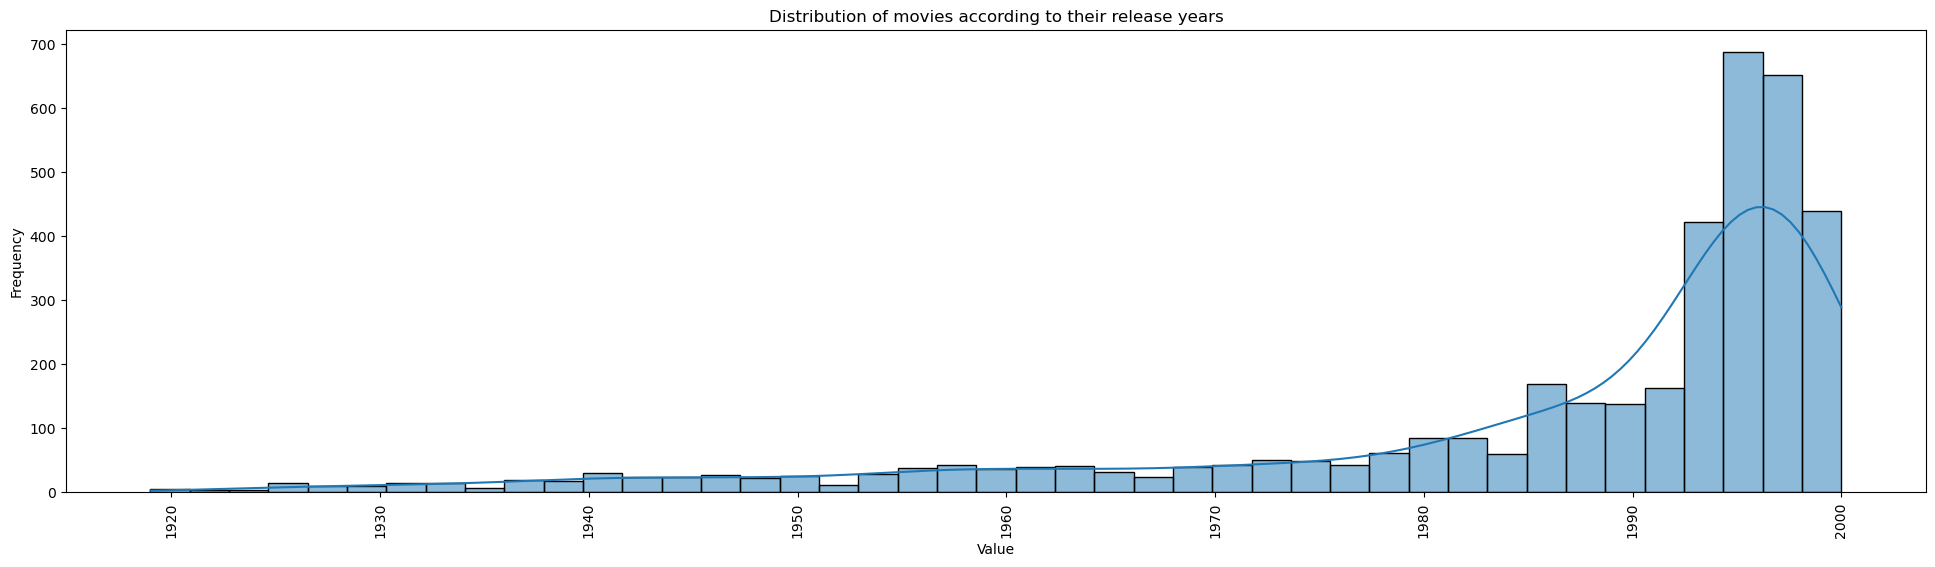

In [26]:
movies = movies.dropna()
movies.release_year = movies.release_year.astype(int)

# Movies release years histogram
plot_hist(np.sort(movies.release_year), "Distribution of movies according to their release years")

In [27]:
users = df_users.copy()

In [28]:
genre_columns = ['Action', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']

def compute_total_genres(row):
    count = 0
    for column in genre_columns:
        count += row[column]
    return count

movies['genre_count'] = movies.apply(lambda row: compute_total_genres(row), axis = 1)


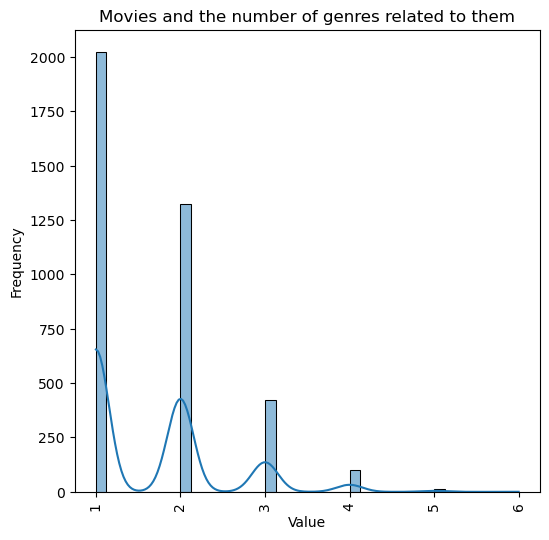

In [29]:
# Movies and no. of genres histogram
plot_hist(np.sort(movies.genre_count), "Movies and the number of genres related to them", (6,6))

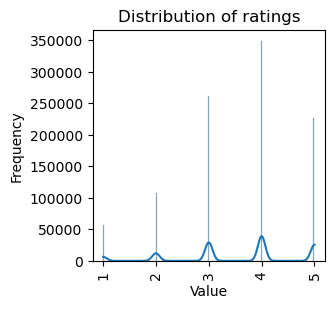

In [30]:
# Ratings distribution
plot_hist(np.sort(ratings.Rating.astype(int)), "Distribution of ratings", (3,3))

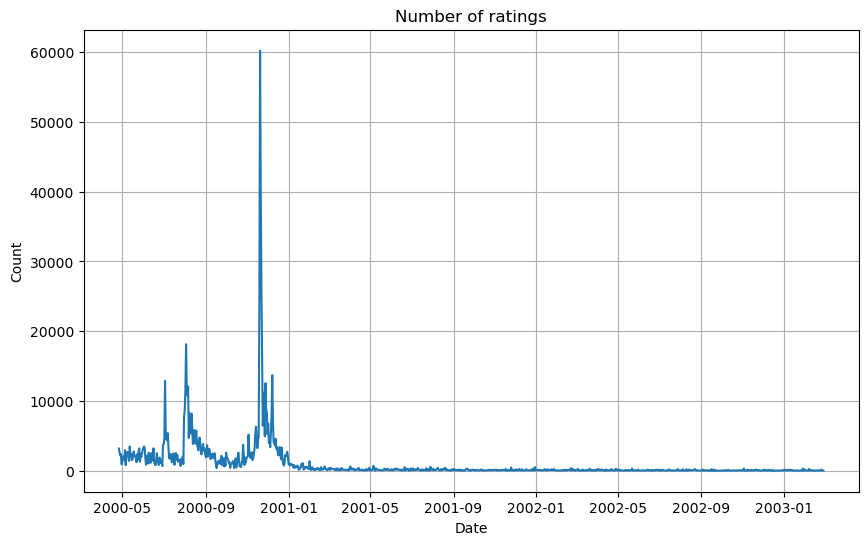

In [31]:
# Timestamp of rating time graph

import matplotlib.pyplot as plt
num_ratings_vs_date = ratings.groupby('date').Rating.count()

# Plotting the time series
plt.figure(figsize=(10, 6))
num_ratings_vs_date.plot()
plt.title('Number of ratings')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [32]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [33]:
# User zipcode mapping

# import folium
# from geopy.geocoders import Nominatim

# # Initialize geolocator
# geolocator = Nominatim(user_agent="geoapiExercises")

# # Function to get latitude and longitude from zip code
# def get_lat_lon(zip_code):
#     try:
#         location = geolocator.geocode(zip_code)
#         print(location.latitude, location.longitude)
#         return location.latitude, location.longitude
#     except:
#         print("This is not done")
#         return None, None

# # Apply the function to get coordinates
# users['lat_lon'] = users['Zip-code'].apply(get_lat_lon)
# users[['latitude', 'longitude']] = pd.DataFrame(users['lat_lon'].tolist(), index=users.index)

# # Create a map centered around the mean latitude and longitude
# map_center = [users['latitude'].mean(), users['longitude'].mean()]
# mymap = folium.Map(location=map_center, zoom_start=5)

# # Add markers to the map
# for idx, row in users.iterrows():
#     folium.Marker(location=[row['latitude'], row['longitude']], popup=row['Zip-code']).add_to(mymap)

# # Save the map to an HTML file
# mymap.save("map.html")


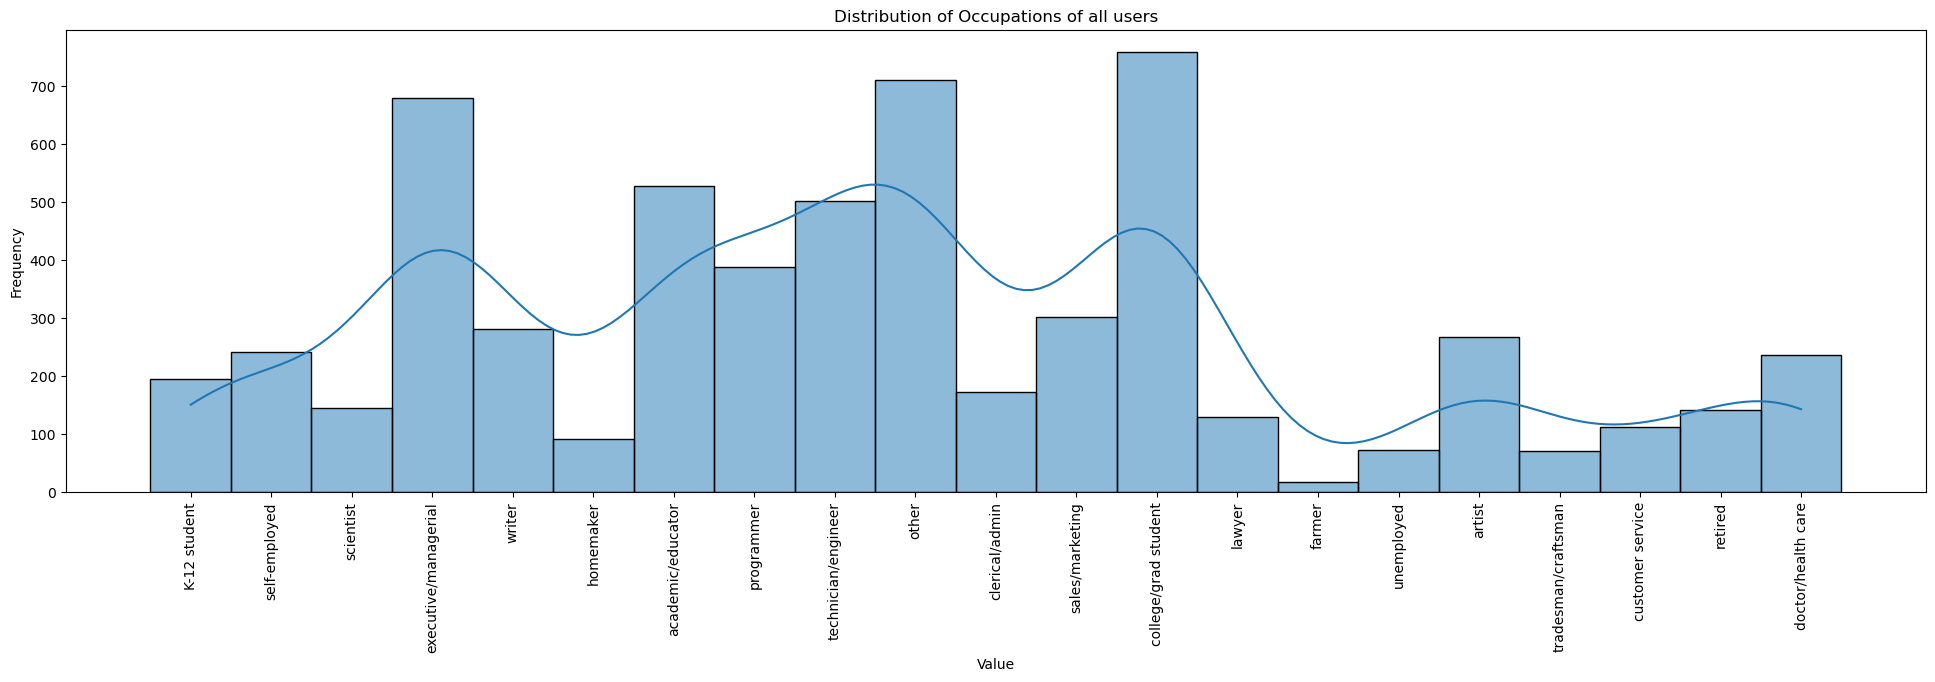

In [34]:
# Occupation histogram for user

occupation_mapping = {
    0: "other",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

users['Occupation_name'] = users.Occupation.apply(lambda x: occupation_mapping[x])

plot_hist(users.Occupation_name, "Distribution of Occupations of all users")

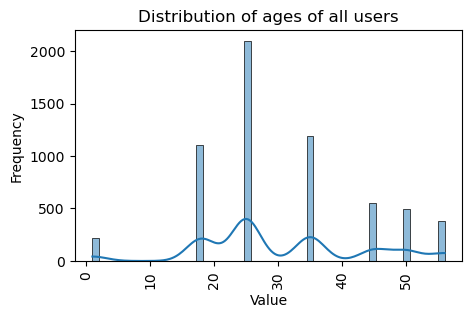

In [35]:
plot_hist(users.Age, "Distribution of ages of all users", figsize=(5,3))

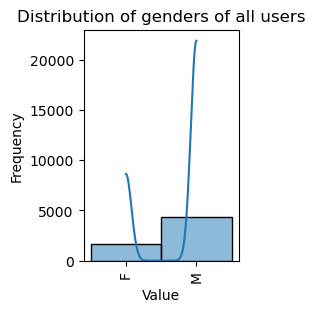

In [36]:
plot_hist(users.Gender, "Distribution of genders of all users", figsize=(2,3))

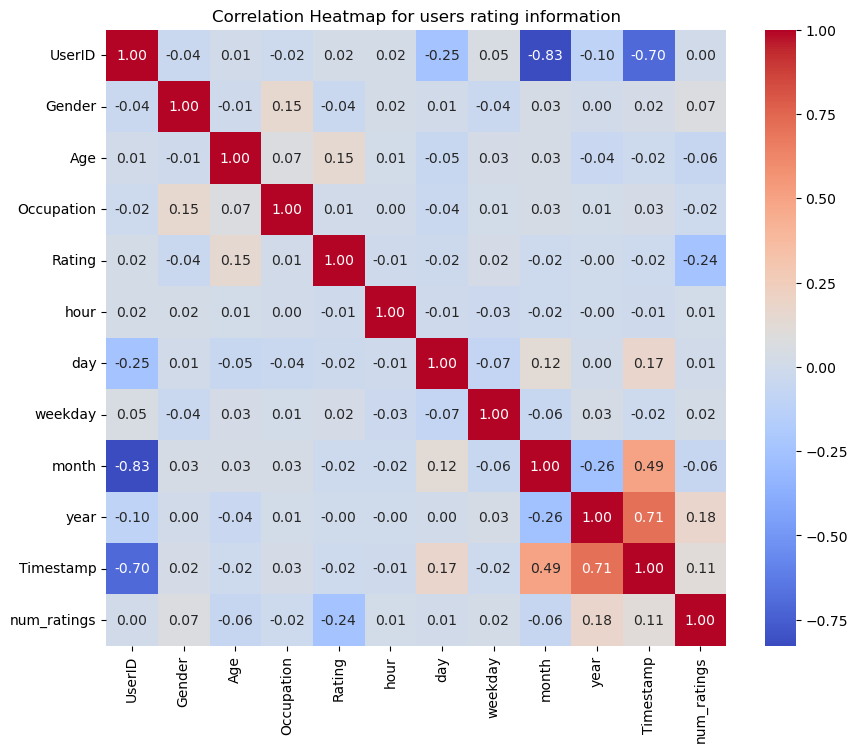

In [37]:
# correlation heatmap for user vs ratings info
def gender_to_num(genderName):
    if genderName == 'M':
        return 1
    else: 
        return 0
users_ratings_stat['Gender'] = users_ratings_stat.Gender.apply(lambda x: gender_to_num(x))
users_ratings_numeric = users_ratings_stat.select_dtypes(include=['int64', 'float64'])

corr = users_ratings_numeric.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap for users rating information')
plt.show()




We can see that there is some correlation between Age and Rating and also between num_ratings and Rating. We should keep these columns while making our recommender system

### Data analysis over

In [38]:
users['num_ratings'] = users_ratings_stat.UserID.apply(lambda x: user_rating_count_mapping[x])
users_movie_rating = ratings.merge(users, on='UserID')
users_movie_rating = users_movie_rating.merge(movies, left_on='MovieID', right_on='Movie ID', how="inner")
users_movie_rating = users_movie_rating[['UserID', 'MovieID', 'Rating', 'movie_name',  'date', 'release_year', 'Action', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'num_ratings']]
users_movie_rating.rename(columns={'date': 'rating_date'}, inplace=True)
users_movie_rating.head()

,UserID,MovieID,Rating,movie_name,rating_date,release_year,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_ratings
0,1,1193,5,One Flew Over the Cuckoo's Nest,2001-01-01,1975,0,0,0,0,...,0,0,0,0,0,0,0,0,0,53
1,2,1193,5,One Flew Over the Cuckoo's Nest,2001-01-01,1975,0,0,0,0,...,0,0,0,0,0,0,0,0,0,129
2,12,1193,4,One Flew Over the Cuckoo's Nest,2000-12-31,1975,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
3,15,1193,4,One Flew Over the Cuckoo's Nest,2000-12-30,1975,0,0,0,0,...,0,0,0,0,0,0,0,0,0,201
4,17,1193,5,One Flew Over the Cuckoo's Nest,2000-12-30,1975,0,0,0,0,...,0,0,0,0,0,0,0,0,0,211


### Recommend using Pearson coefficient

In [39]:
from scipy.stats import pearsonr

def string_to_numeric_array(s):
    return np.array([ord(char) for char in s])

def top_correlated_movies(input_string, movie_list, top_n=5):
    input_numeric_array = string_to_numeric_array(input_string.lower())
    correlations = []

    for movie in movie_list:
        if(len(movie) > 2):
            shorter_movie_length = min(len(input_numeric_array), len(movie))
            movie_numeric_array = string_to_numeric_array(movie.lower())
            correlation, _ = pearsonr(input_numeric_array[0:shorter_movie_length], movie_numeric_array[0:shorter_movie_length])
            correlations.append((movie, correlation))

    # Sort correlations based on the absolute value of correlation coefficient (higher is better)
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    # Get the top n movies with highest correlations
    top_movies = correlations[:top_n]

    return top_movies

top_movies=[]
# Example input from user
user_input = input("Enter a movie name: ")
if(len(user_input) < 2):
    print("Input of length less that 2 is not accepted")
else:
    # Find top 5 movies with highest Pearson correlation coefficient
    top_movies = top_correlated_movies(user_input, list(movies.movie_name))

    # Print the results
    print(f"\nTop 5 movies most correlated with '{user_input}':")
    for i, (movie, correlation) in enumerate(top_movies, 1):
        print(f"{i}. {movie} (Correlation: {correlation:.2f})")



Enter a movie name: Toy Story

Top 5 movies most correlated with 'Toy Story':
1. Toy Story (Correlation: 1.00)
2. Toy Story 2 (Correlation: 1.00)
3. Kim (Correlation: 1.00)
4. Kika (Correlation: 0.99)
5. Man Facing Southeast (Hombre Mirando al Sudeste) (Correlation: 0.99)


### Recommend using Cosine Similarity

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

user_input = input("Enter a movie to check which are the most relevant movies with it: ")

temp = movies[['Action', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']]

# Compute the cosine similarity matrix
movie_similarity_matrix = cosine_similarity(temp)

# Convert the matrix to a DataFrame for better readability
movie_similarity_matrix_df = pd.DataFrame(movie_similarity_matrix, index=movies.movie_name, columns=movies.movie_name)
if user_input in (movie_similarity_matrix_df.index):
    results = movie_similarity_matrix_df.loc[user_input].sort_values(ascending=False)[0:6]
    if(user_input in results.index):
        results.drop(user_input, inplace=True)


    # Print the results
    print(f"\nTop 5 movies most correlated with '{user_input}' according to cosine similarity: ")
    for i in range(5):
        movie = results.index[i]
        correlation = results[i]
        print(f"{i+1}. {movie} (Correlation: {correlation:.2f})")
else:
    print("Movie not found in database. Please try with some other movie name.")




Enter a movie to check which are the most relevant movies with it: Toy Story

Top 5 movies most correlated with 'Toy Story' according to cosine similarity: 
1. American Tail: Fievel Goes West, An (Correlation: 1.00)
2. Rugrats Movie, The (Correlation: 1.00)
3. Toy Story 2 (Correlation: 1.00)
4. Chicken Run (Correlation: 1.00)
5. Adventures of Rocky and Bullwinkle, The (Correlation: 1.00)


In [44]:
movie_similarity_matrix_df.head()

movie_name,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Bamboozled,Bootmen,Digimon: The Movie,Get Carter,Get Carter,Meet the Parents,Requiem for a Dream,Tigerland,Two Family House,"Contender, The"
movie_name,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.333333,0.408248,0.408248,0.577350,0.0,0.408248,0.408248,0.0,0.000000,...,0.577350,0.408248,0.666667,0.000000,0.0,0.577350,0.000000,0.000000,0.000000,0.0
Jumanji,0.333333,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.816497,0.0,0.333333,...,0.000000,0.000000,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Grumpier Old Men,0.408248,0.000000,1.000000,0.500000,0.707107,0.0,1.000000,0.000000,0.0,0.000000,...,0.707107,0.500000,0.000000,0.000000,0.0,0.707107,0.000000,0.000000,0.000000,0.0
Waiting to Exhale,0.408248,0.000000,0.500000,1.000000,0.707107,0.0,0.500000,0.000000,0.0,0.000000,...,0.707107,1.000000,0.000000,0.408248,0.0,0.707107,0.707107,0.707107,0.707107,0.5
Father of the Bride Part II,0.577350,0.000000,0.707107,0.707107,1.000000,0.0,0.707107,0.000000,0.0,0.000000,...,1.000000,0.707107,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0


In [45]:

users['Gender_numeric'] = users.Gender.apply(lambda x: gender_to_num(x))
temp = users[['Gender_numeric', 'Age', 'Occupation', 'num_ratings']]

# Compute the cosine similarity matrix
user_similarity_matrix = cosine_similarity(temp)

user_similarity_matrix_df = pd.DataFrame(user_similarity_matrix, index=users.UserID, columns=users.UserID)

user_similarity_matrix_df.head()


UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.923727,0.908048,0.453834,0.990679,0.828739,0.668963,0.982445,0.977570,0.980841,...,0.932651,0.918728,0.786609,0.666627,0.980902,0.985615,0.963900,0.350974,0.929051,0.984316
2,0.923727,1.000000,0.988445,0.752428,0.960317,0.979433,0.902616,0.973160,0.983634,0.942621,...,0.991113,0.998667,0.959070,0.861595,0.943364,0.923944,0.976151,0.680934,0.991846,0.939738
3,0.908048,0.988445,1.000000,0.781114,0.935468,0.975935,0.899476,0.948017,0.970738,0.902372,...,0.960161,0.979641,0.968550,0.913300,0.903334,0.883846,0.941006,0.696861,0.961383,0.901206
4,0.453834,0.752428,0.781114,1.000000,0.539125,0.868662,0.952147,0.580749,0.627759,0.495429,...,0.693379,0.747841,0.906890,0.934022,0.497281,0.446037,0.604387,0.987887,0.701414,0.485568
5,0.990679,0.960317,0.935468,0.539125,1.000000,0.884476,0.749728,0.998525,0.992962,0.994510,...,0.972371,0.959825,0.843149,0.710423,0.994688,0.991825,0.991119,0.451014,0.969895,0.995244


### Recommend using KNN and Cosine Similarity sklearn

In [46]:
dataset = pd.merge(ratings, movies, left_on='MovieID', right_on='Movie ID')

In [47]:
dataset = dataset[['UserID', 'movie_name', 'Rating']]
dataset.head()

,UserID,movie_name,Rating
0,1,One Flew Over the Cuckoo's Nest,5
1,2,One Flew Over the Cuckoo's Nest,5
2,12,One Flew Over the Cuckoo's Nest,4
3,15,One Flew Over the Cuckoo's Nest,4
4,17,One Flew Over the Cuckoo's Nest,5


In [48]:
table = dataset.pivot_table(index='movie_name', columns='UserID', values='Rating')

In [49]:
table = table.fillna(0)
table.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_name,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Night Mother,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
'Til There Was You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
table.loc['Toy Story', :].values.reshape(1, -1)

array([[5., 0., 0., ..., 0., 0., 3.]])

<Axes: ylabel='Rating'>

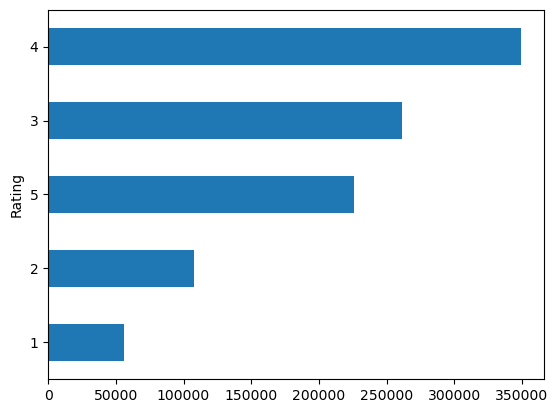

In [51]:
dataset.Rating.value_counts().sort_values().plot(kind='barh')

In [52]:
table.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
from scipy.sparse import csr_matrix

matrix = csr_matrix(table.values)

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric= 'cosine', algorithm= 'brute')
knn.fit(matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [55]:
user_query_index = np.random.choice(table.shape[1])
user_query_index

212

In [56]:
table.index[user_query_index]

'Artemisia'

In [57]:
table.iloc[user_query_index, :]

UserID
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
6036    0.0
6037    0.0
6038    0.0
6039    0.0
6040    0.0
Name: Artemisia, Length: 6040, dtype: float64

In [58]:
input_data = table.iloc[user_query_index, :].values.reshape(1, -1)
distances, indices = knn.kneighbors(input_data, n_neighbors = 6)

Generating recommendation using KNN for the selected movie

In [59]:
for i in range(0, len(distances.flatten())):
    # the below line will be printed anyway
    # we always start i = 0
    # just getting the variable i ready to print for which book we are
    # generating the recommendation for:
    if i == 0:
        print('Recommendation for {0}:\n'.format(table.index[user_query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, table.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendation for Artemisia:

1: Conceiving Ada, with distance of 0.6776175236255572:
2: Live Flesh, with distance of 0.7217993936103348:
3: Modern Affair, A, with distance of 0.7321808008165558:
4: School of Flesh, The (L' École de la chair), with distance of 0.7606827894347603:
5: Bloody Child, The, with distance of 0.7673789474003823:


### Recommend using matrix factorization

Using cmfrec library
Collective matrix factorisation for recommender systems
Documentation: https://cmfrec.readthedocs.io/en/latest/

- cmfrec library requires input in the form of dataframe not as sparse matrix.

- It required 3 columns UserId, ItemId, Rating.

- An instance of the CMF model is created with various hyperparameters:

- method="als": Specifies the alternating least squares (ALS) optimization method, commonly used for matrix factorization in recommendation systems.

- k=2: Sets the number of latent factors to 2, determining the dimensionality of the latent factor space.

- lambda_=0.1: Sets the regularization strength to 0.1. Regularization is used to prevent overfitting in the model.

- user_bias=False: Indicates that user bias terms are not included in the model. User bias represents a user's overall rating tendency.

- item_bias=False: Excludes item bias terms in the model. Item bias represents an item's overall rating tendency.

- verbose=False: Suppresses verbose output, controlling whether the model's training progress is displayed.

In [60]:
rm_raw = ratings[['UserID', 'MovieID', 'Rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
rm_raw.head()

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [63]:
!pip install cmfrec


  Using cached cmfrec-3.5.1.post10-cp311-cp311-macosx_14_0_arm64.whl
  Obtaining dependency information for cython from https://files.pythonhosted.org/packages/b6/83/b0a63fc7b315edd46821a1a381d18765c1353d201246da44558175cddd56/Cython-3.0.10-py2.py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.25 from https://files.pythonhosted.org/packages/01/4a/611a907421d8098d5edc8c2b10c3583796ee8da4156f8f7de52c2f4c9d90/numpy-2.0.0-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Obtaining dependency information for numpy>=1.25 from https://files.pythonhosted.org/packages/1a/2e/151484f49fd03944c4a3ad9c418ed193cfd02724e138ac8a9505d056c582/numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.4 MB/s eta 

In [64]:
from cmfrec import CMF
import time

model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

start = time.time()
model.fit(rm_raw)
end = time.time()
print(f"Time Elapsed in trainig: {end-start}")

Time Elapsed in trainig: 1.2690629959106445


In [65]:
model.A_.shape, model.B_.shape

((6040, 2), (3706, 2))

In [66]:
rm_raw.Rating.mean(), model.glob_mean_

(3.581564453029317, 3.581564426422119)

In [67]:
rm = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
from sklearn.metrics import mean_squared_error as mse
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
print("MSE for the above model: " + str(mse(rm.values[rm > 0], rm__[rm > 0])**0.5))

MSE for the above model: 1.3043536493177685


In [69]:
from sklearn.metrics import mean_absolute_percentage_error as mape
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
print("MAPE for the above model: " + str(mape(rm.values[rm > 0], rm__[rm > 0])**0.5))

MAPE for the above model: 0.6136484117493751


In [70]:
movies.head()

Genres,Movie ID,movie_name,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre_count
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [71]:
# n: no of items to recommend
top_items = model.topN(user=10, n=10)
movies.loc[movies["Movie ID"].isin(top_items)]

Genres,Movie ID,movie_name,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre_count
638,643,Peanuts - Die Bank zahlt alles,1996,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
883,895,Venice/Venice,1992,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1397,1421,Grateful Dead,1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2469,2538,Dancemaker,1998,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2754,2823,"Spiders, The (Die Spinnen, 1. Teil: Der Golden...",1919,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2842,2911,"Grandfather, The (El Abuelo)",1998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3311,3380,Railroaded!,1947,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3462,3531,All the Vermeers in New York,1990,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,3
3748,3818,Pot O' Gold,1941,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,2
3822,3892,Anatomy (Anatomie),2000,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


#### Calculating Average OverLap

avg_perc_overlap: 0.3445217280326718


<Axes: >

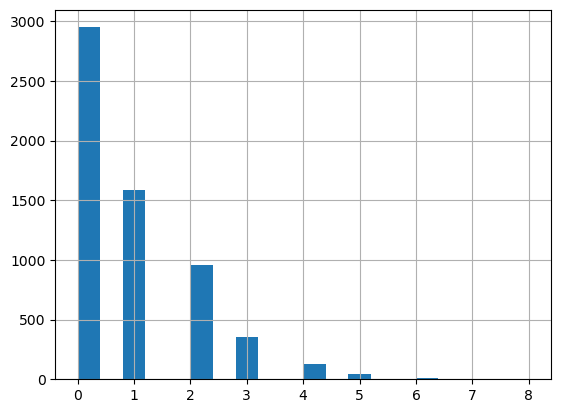

In [72]:
overlap= []
num_rec = []
n = 20
for user in ratings.UserID.unique():
    top_items = model.topN(user=user, n=n)
    user_movies = ratings.loc[(ratings.UserID==user)].MovieID
    valid_rec = set(top_items).intersection(set(user_movies)) # I can only measure by what was in the training data

    _ = len(set(ratings.loc[ratings.UserID==user].sort_values(by='Rating', ascending=False).head(n).MovieID).intersection(set(valid_rec)))
    overlap.append(_)
    num_rec.append(len(valid_rec))

print('avg_perc_overlap:', np.array(overlap).mean() / np.array(num_rec).mean())
pd.Series(overlap).hist(bins=20)

K-precision

Out of K predictions, how many of those K were relevant?

avg: 0.7941254267523916


<Axes: >

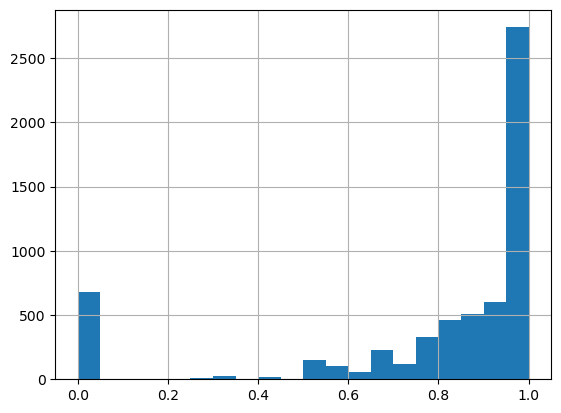

In [73]:
overlap=[]

for user in ratings.UserID.unique():
    recommendations = model.topN(user=user, n=100)
    user_movies = ratings.loc[(ratings.UserID==user)].MovieID
    valid_rec = set(recommendations).intersection(set(user_movies)) # I can only measure by what was in the training data
    relevant_items = ratings.loc[(ratings.UserID==user) & (ratings.Rating>=4)].MovieID
    try:
        _ = len(set(recommendations).intersection(set(relevant_items))) / len(valid_rec)
    except:
        _ = 0
    overlap.append(_)

overlap = np.array(overlap)
print('avg:', overlap.mean())
pd.Series(overlap).hist(bins=20)

#### Item-Item and User-User similarity matrix using MF embeddings with d = 4

In [74]:
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

model.fit(rm_raw)

print(model.A_.shape, model.B_.shape)

(6040, 4) (3706, 4)


In [75]:
embedded_users_array = model.A_
embedded_users_df = pd.DataFrame(embedded_users_array)
embedded_users_df['UserID'] = embedded_users_df.index + 1
embedded_users_df.head()

,0,1,2,3,UserID
0,-0.127591,-0.152649,0.073956,0.014985,1
1,-0.166674,-0.115769,-0.262104,-0.270889,2
2,-0.119248,0.011038,-0.332830,0.127275,3
3,0.263413,-0.338235,-0.211824,-0.356052,4
4,0.439278,0.028768,-0.210001,-0.103933,5


In [76]:
embedded_movies_array = model.B_
embedded_movies_df = pd.DataFrame(embedded_movies_array)
embedded_movies_df['MovieID'] = embedded_movies_df.index + 1
embedded_movies_df = embedded_movies_df.merge(movies, left_on='MovieID', right_on='Movie ID', how="inner")
embedded_movies_df = embedded_movies_df[['MovieID',   'movie_name', 0, 1, 2, 3]]
embedded_movies_df.head()

,MovieID,movie_name,0,1,2,3
0,1,Toy Story,0.681755,-4.451891,-1.456907,0.623703
1,2,Jumanji,0.305415,-1.293005,2.252264,0.792580
2,3,Grumpier Old Men,-1.629499,-3.767879,0.057835,-1.566576
3,4,Waiting to Exhale,-2.297714,-2.023359,-0.242263,-0.194461
4,5,Father of the Bride Part II,-1.275383,-2.542525,0.067054,0.132657


In [77]:
temp = embedded_movies_df[[0, 1, 2, 3]]

# Compute the cosine similarity matrix
movie_similarity_matrix = cosine_similarity(temp)

# Convert the matrix to a DataFrame for better readability
movie_similarity_matrix_df = pd.DataFrame(movie_similarity_matrix, index=embedded_movies_df.movie_name, columns=embedded_movies_df.movie_name)

movie_similarity_matrix_df.head()

movie_name,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Predator 2,"Running Man, The",Starman,"Brother from Another Planet, The",Alien Nation,Mad Max,Mad Max 2 (a.k.a. The Road Warrior),Mad Max Beyond Thunderdome,Bird on a Wire,Angel Heart
movie_name,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.243567,0.695979,0.522231,0.767282,0.948973,0.807188,0.969814,0.588493,0.849512,...,0.187683,-0.187683,0.068096,-0.342019,0.401123,0.942487,-0.882572,-0.130158,0.194384,0.875937
Jumanji,0.243567,1.000000,0.271746,0.144460,0.405268,0.126584,0.124824,0.213427,0.468337,0.284281,...,0.787033,-0.787033,0.824836,0.703748,0.551256,0.240298,-0.051833,0.393247,-0.520400,0.226801
Grumpier Old Men,0.695979,0.271746,1.000000,0.862147,0.915132,0.758269,0.914218,0.798084,0.954136,0.962745,...,0.644434,-0.644434,-0.130242,0.183969,0.815102,0.499973,-0.856117,0.291255,0.569964,0.298411
Waiting to Exhale,0.522231,0.144460,0.862147,1.000000,0.916435,0.724711,0.917738,0.710791,0.734096,0.752316,...,0.493285,-0.493285,-0.015271,0.171955,0.507551,0.215608,-0.832180,-0.097018,0.756488,0.053800
Father of the Bride Part II,0.767282,0.405268,0.915132,0.916435,1.000000,0.864234,0.953834,0.882289,0.833508,0.893178,...,0.592788,-0.592788,0.183414,0.161865,0.630446,0.532296,-0.902946,-0.010381,0.487669,0.389199


In [78]:
temp = embedded_users_df[[0, 1, 2, 3]]

# Compute the cosine similarity matrix
user_similarity_matrix = cosine_similarity(temp)

# Convert the matrix to a DataFrame for better readability
user_similarity_matrix_df = pd.DataFrame(user_similarity_matrix, index=embedded_users_df.UserID, columns=embedded_users_df.UserID)

user_similarity_matrix_df.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.170103,-0.114736,-0.023483,-0.730620,0.198021,0.706207,0.302334,-0.263075,0.956633,...,-0.087113,-0.199153,0.235181,-0.490261,-0.385200,-0.309235,-0.260994,0.150330,0.075981,-0.508371
2,0.170103,1.000000,0.443404,0.576851,0.031150,0.898441,-0.010590,-0.154776,0.357164,0.427887,...,0.716629,0.190380,0.967050,-0.398616,0.475633,0.297296,0.676744,0.820793,0.827002,0.249295
3,-0.114736,0.443404,1.000000,-0.044441,0.024544,0.189157,0.391775,0.455016,0.822323,0.058423,...,0.701142,-0.132900,0.555875,-0.192374,0.514526,-0.029510,0.297888,-0.071948,0.422620,-0.025062
4,-0.023483,0.576851,-0.044441,1.000000,0.630551,0.330476,-0.083172,0.082339,0.381510,0.046103,...,-0.090641,0.899136,0.357558,0.440751,0.745867,0.918480,0.917035,0.859293,0.865973,0.847021
5,-0.730620,0.031150,0.024544,0.630551,1.000000,-0.211846,-0.415672,0.059542,0.502422,-0.728975,...,-0.226129,0.812116,-0.166764,0.844038,0.784255,0.866427,0.722518,0.276507,0.426876,0.946257


Get d=2 embeddings, and plot the results. Write down your analysis from this visualisation. (Compare with other visualization techniques)

In [80]:
# Modelling MF embedding with d = 2
model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(rm_raw)
print(model.A_.shape, model.B_.shape)

# Computing embedded users array
embedded_users_array = model.A_
embedded_users_df = pd.DataFrame(embedded_users_array)
embedded_users_df['UserID'] = embedded_users_df.index + 1

# Computing movies users array
embedded_movies_array = model.B_
embedded_movies_df = pd.DataFrame(embedded_movies_array)
embedded_movies_df['MovieID'] = embedded_movies_df.index + 1
embedded_movies_df = embedded_movies_df.merge(movies, left_on='MovieID', right_on='Movie ID', how="inner")
embedded_movies_df = embedded_movies_df[['MovieID',   'movie_name', 0, 1]]

# Computing cosine similarity for movies array
temp = embedded_movies_df[[0, 1]]
movie_similarity_matrix = cosine_similarity(temp)
movie_similarity_matrix_df = pd.DataFrame(movie_similarity_matrix, index=embedded_movies_df.movie_name, columns=embedded_movies_df.movie_name)

# Computing cosine similarity for users array
temp = embedded_users_df[[0, 1]]
user_similarity_matrix = cosine_similarity(temp)
user_similarity_matrix_df = pd.DataFrame(user_similarity_matrix, index=embedded_users_df.UserID, columns=embedded_users_df.UserID)


(6040, 2) (3706, 2)


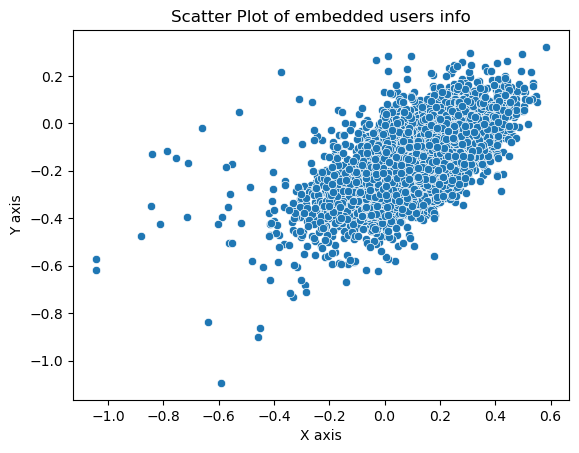

In [81]:
sns.scatterplot(x=embedded_users_df[0], y=embedded_users_df[1])

# Adding labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Scatter Plot of embedded users info')

# Show plot
plt.show()

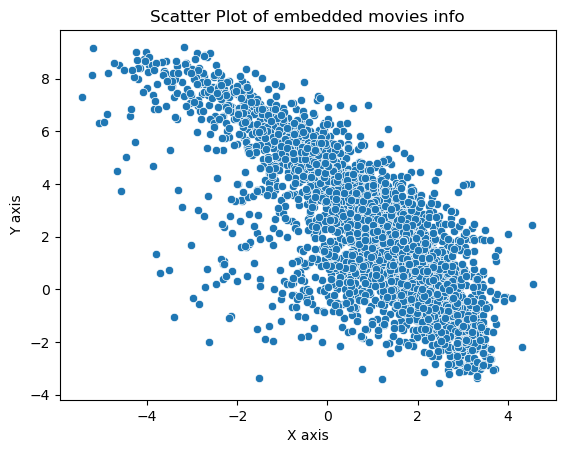

In [82]:
sns.scatterplot(x=embedded_movies_df[0], y=embedded_movies_df[1])

# Adding labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Scatter Plot of embedded movies info')

# Show plot
plt.show()

In [83]:
def get_decade(year):
    # Ensure the input is an integer
    try:
        year = int(year)
    except ValueError:
        return "Invalid input. Please enter a valid year."

    # Calculate the decade
    decade = (year // 10) * 10
    return decade - 1900

movies['decade'] = movies['release_year'].apply(lambda x: get_decade(x))
movies.groupby('decade').decade.value_counts().sort_values(ascending=False)


decade
90     2283
80      597
70      247
60      191
50      168
100     156
40      126
30       77
20       34
10        3
Name: count, dtype: int64

In [84]:
ratings.groupby('MovieID').count().sort_values(by=['UserID'], ascending=False)
movies[movies['Movie ID'] == 2858]

Genres,Movie ID,movie_name,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genre_count,decade
2789,2858,American Beauty,1999,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,90


## Questions:

- Users of which age group have watched and rated the most number of movies?
        
        25-34

- Users belonging to which profession have watched and rated the most movies?
        
        College/Student

- Most of the users in our dataset who’ve rated the movies are Male. (T/F)
        
        True

- Most of the movies present in our dataset were released in which decade? a. 70s b. 90s c. 50s d.80s

        90s

- The movie with maximum no. of ratings is ___.

        American Beauty

- Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
        
        1. Castle, The (Correlation: 1.00)
        2. Night Shift (Correlation: 1.00)
        3. EDtv (Correlation: 1.00)

- On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

        1. Item
        2. User

- Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.

        1. -1 to 1
        2. 0 to 1

- Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

        MSE for the above MF model: 1.3043536493177685
        MAPE for the above MF model: 0.6149695011299233

- Give the sparse ‘row’ matrix representation for the following dense matrix - [[1 0] [3 7]]

        Row indices: [0, 1, 1]
        Column indices: [0, 0, 1]
        Values: [1, 3, 7]

        